# Проект: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

#### «Цель»:  
Построить модель (MAE на тестовой выборке <=6.8), которая будет предсказывать температуру сплава

### Импорт библиотек 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Шаг 1. Загрузка данных

In [2]:
def dataset_load_and_info(path,name):
    try:
        dataset=pd.read_csv(path,sep=',')
    except:
        display('ОШИБКА В ЧТЕНИИ ФАЙЛА')
    display(f'Анализ датафрейма {name}')
    display(dataset.head(5))
    display(dataset.describe())
    display(f'Размер датафрейма')
    display(dataset.shape)
    display(f'Количество пустых ячеек:')
    display(dataset.isnull().sum())
    display(dataset.info())
    display(f'Количество явных дубликатов в датасете:{dataset.duplicated().sum()}' )
    return dataset

In [3]:
data_arc_new=dataset_load_and_info('https://code.s3.yandex.net/datasets/data_arc_new.csv','data_arc_new')

'Анализ датафрейма data_arc_new'

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284

'Размер датафрейма'

(14876, 5)

'Количество пустых ячеек:'

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

'Количество явных дубликатов в датасете:0'

#### Вывод: В data_arc_new отсутствуют пустые ячейки и дубликаты. Для столбцов в "Начало нагрева дугой" и "Конец нагрева дугой" необходимо извенить формат на datetime

In [4]:
data_bulk_new=dataset_load_and_info('https://code.s3.yandex.net/datasets/data_bulk_new.csv','data_bulk_new')

'Анализ датафрейма data_bulk_new'

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

'Размер датафрейма'

(3129, 16)

'Количество пустых ячеек:'

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


None

'Количество явных дубликатов в датасете:0'

#### Вывод: В data_bulk_new отсутствуют и дубликаты. Имеются пустые ячейки

In [5]:
data_bulk_time_new=dataset_load_and_info('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv','data_bulk_time_new')

'Анализ датафрейма data_bulk_time_new'

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000

'Размер датафрейма'

(3129, 16)

'Количество пустых ячеек:'

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


None

'Количество явных дубликатов в датасете:0'

#### Вывод: В data_bulk_time_new отсутствуют дубликаты. Имеются пустые ячейки. Для столбцов BULK необходимо извенить формат на datetime

In [6]:
data_gas_new=dataset_load_and_info('https://code.s3.yandex.net/datasets/data_gas_new.csv','data_gas_new')

'Анализ датафрейма data_gas_new'

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

'Размер датафрейма'

(3239, 2)

'Количество пустых ячеек:'

key      0
Газ 1    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

'Количество явных дубликатов в датасете:0'

#### Вывод: В data_gas_new отсутствуют пустые ячейки и дубликаты.

In [7]:
data_temp_new=dataset_load_and_info('https://code.s3.yandex.net/datasets/data_temp_new.csv','data_temp_new')

'Анализ датафрейма data_temp_new'

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000

'Размер датафрейма'

(18092, 3)

'Количество пустых ячеек:'

key                0
Время замера       0
Температура     3427
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

'Количество явных дубликатов в датасете:0'

#### Вывод: В data_temp_new отсутствуют дубликаты. Имеются пустые ячейки. Для столбца "Время замера" необходимо извенить формат на datetime

In [8]:
data_wire_new=dataset_load_and_info('https://code.s3.yandex.net/datasets/data_wire_new.csv','data_wire_new')

'Анализ датафрейма data_wire_new'

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

'Размер датафрейма'

(3081, 10)

'Количество пустых ячеек:'

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

'Количество явных дубликатов в датасете:0'

#### Вывод: В data_wire_new отсутствуют дубликаты. Имеются пустые ячейки. 

In [9]:
data_wire_time_new=dataset_load_and_info('https://code.s3.yandex.net/datasets/data_wire_time_new.csv','data_wire_time_new')

'Анализ датафрейма data_wire_time_new'

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

'Размер датафрейма'

(3081, 10)

'Количество пустых ячеек:'

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

'Количество явных дубликатов в датасете:0'

#### Вывод: В data_wire_time_new отсутствуют дубликаты. Имеются пустые ячейки. Для столбцов WIRE необходимо извенить формат на datetime

### Шаг 2. Исследовательский анализ и предобработка данных

In [10]:
def graphs(dataset,name):
    display(f'Анализ количественных признаков датафрейма {name}')
    for j in dataset.columns:
        if (dataset[j].dtype!= object) and j!="key":
            fig = plt.hist(dataset[j],color = 'blue', edgecolor = 'black',bins = 50)
            plt.xlabel(j)
            plt.ylabel('Количество')
            plt.title(f'Анализ столбца {j}',fontweight = "bold")
            plt.show()
            dataset.boxplot([j],vert=False, patch_artist = True, boxprops = dict(facecolor = "blue"), grid= False, color='blue')
            plt.title(f'Boxplot для  столбца {j}',fontweight = "bold")
            plt.show()

'Анализ количественных признаков датафрейма data_arc_new'

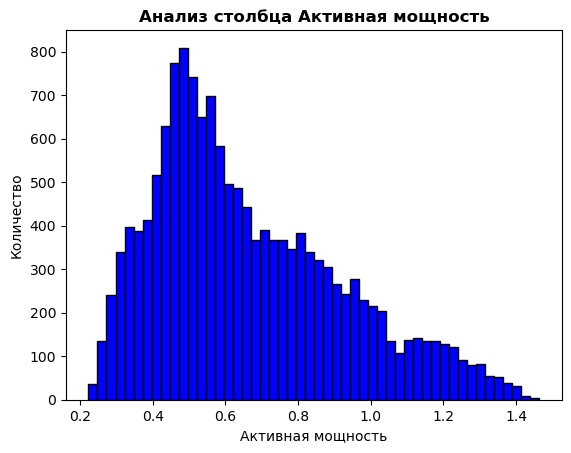

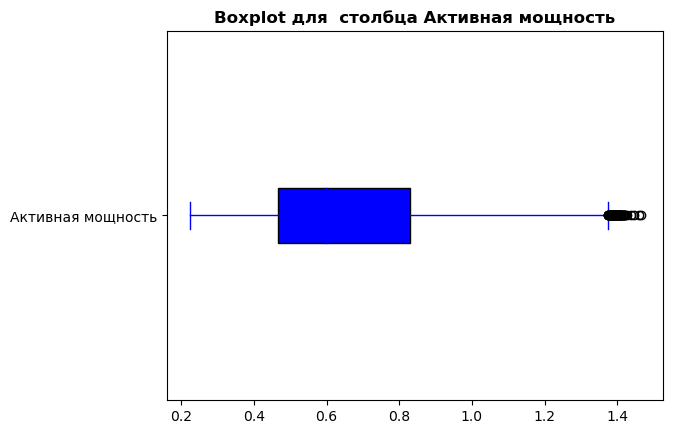

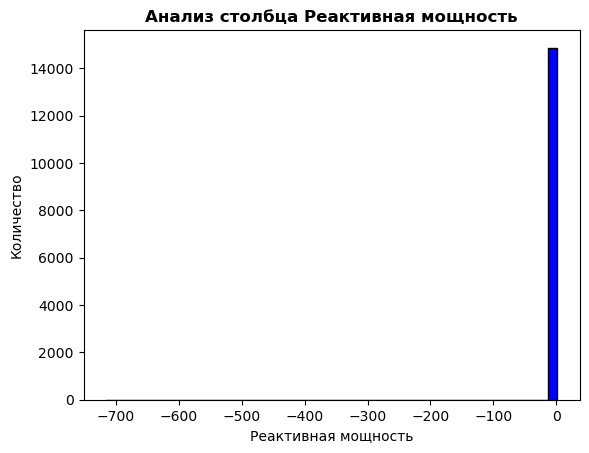

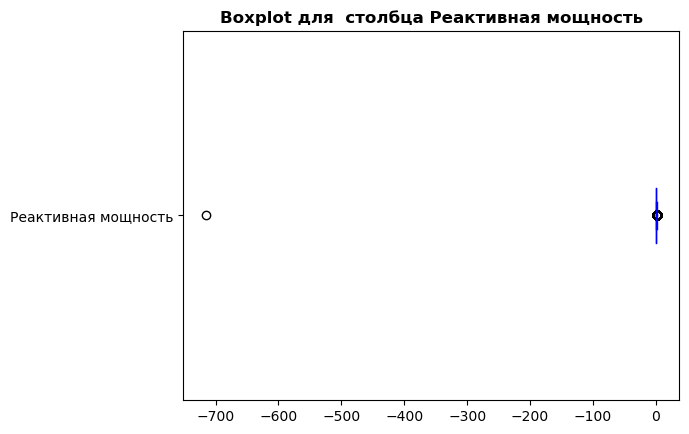

In [11]:
graphs(data_arc_new,'data_arc_new')

#### Вывод: data_arc_new['Реативная мощность'] есть выборос в -715 градусов

'Анализ количественных признаков датафрейма data_bulk_new'

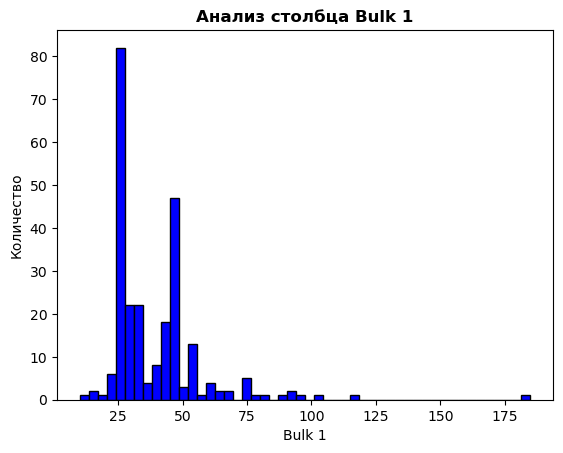

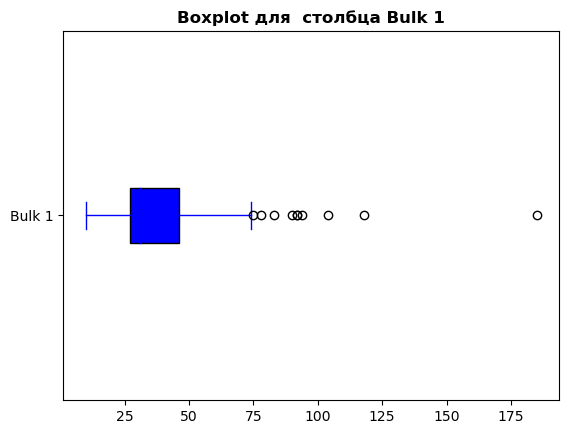

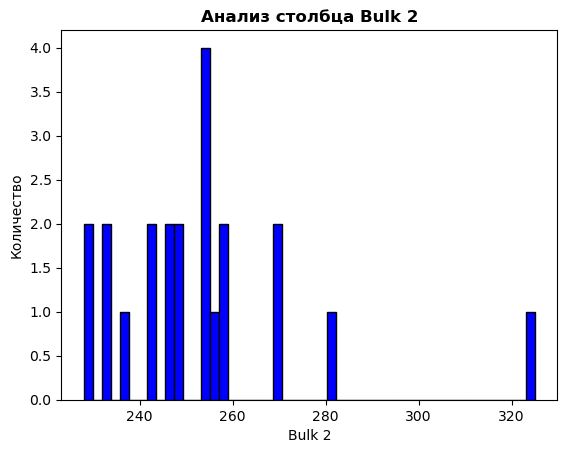

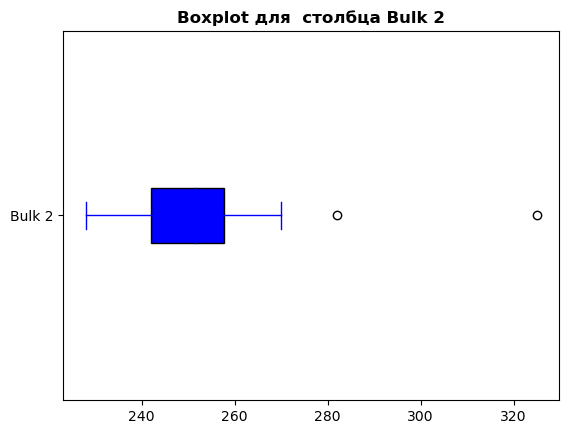

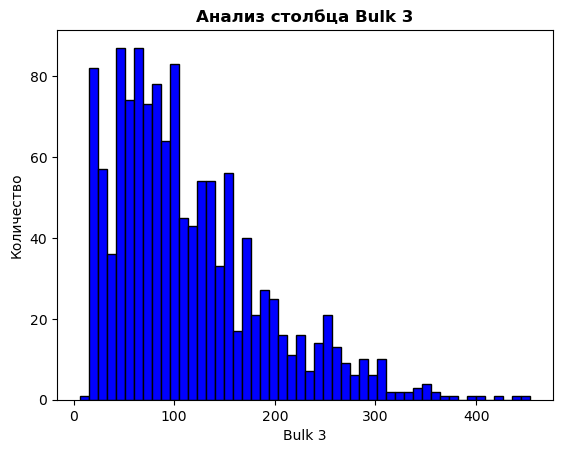

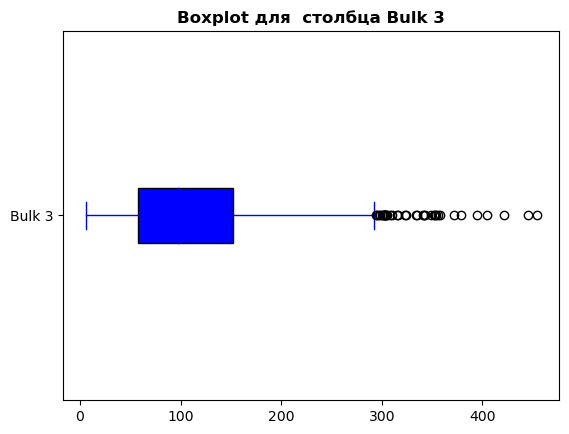

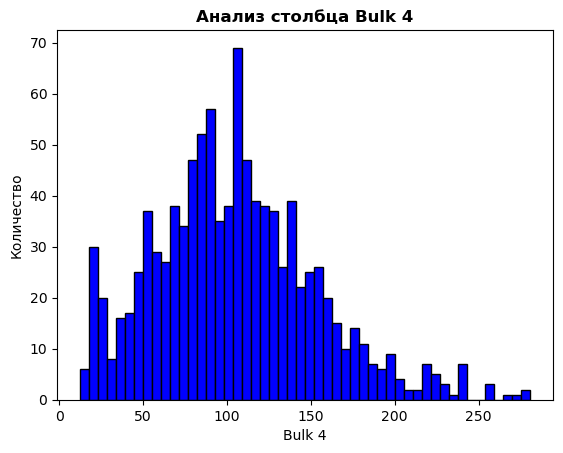

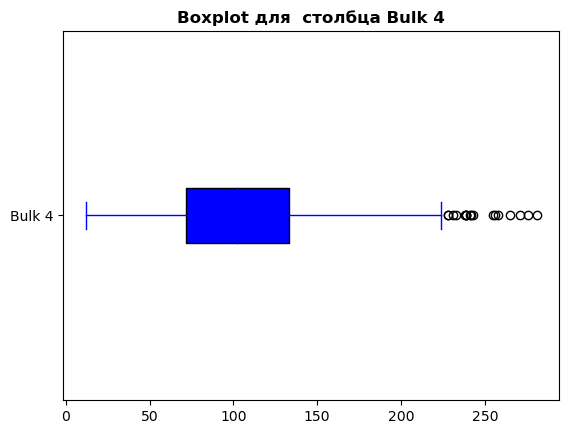

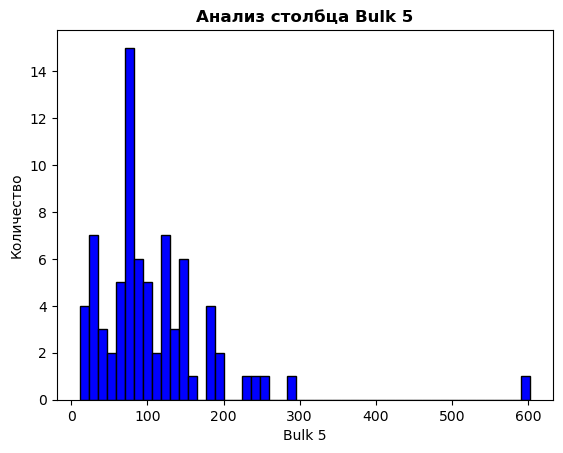

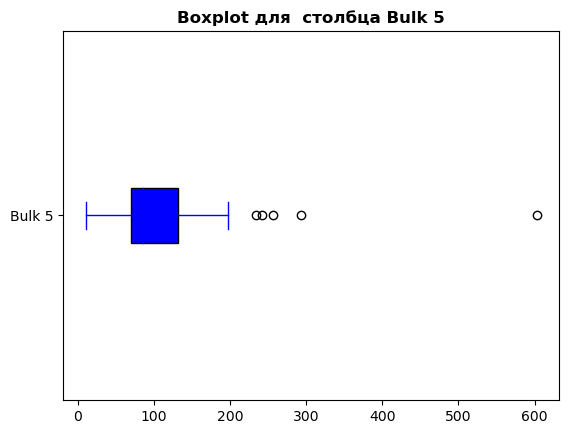

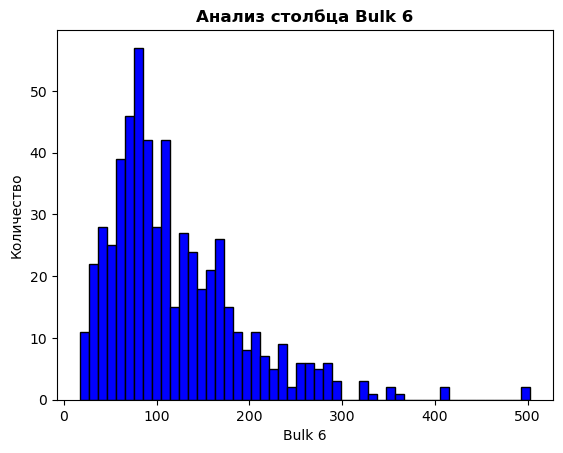

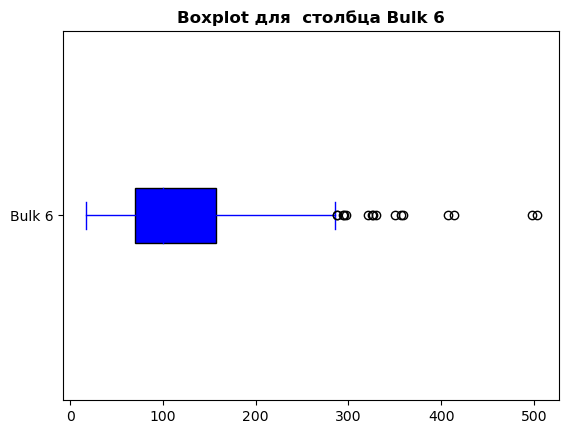

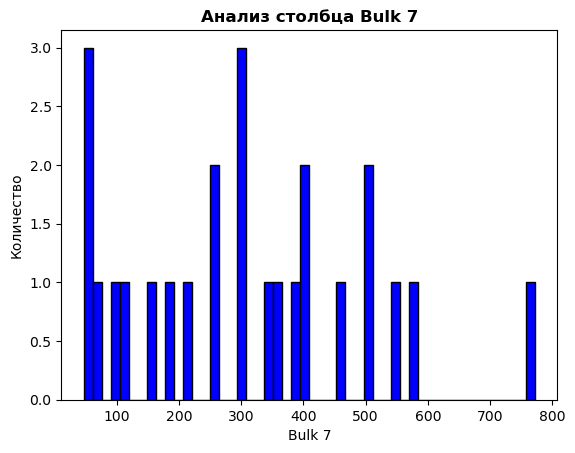

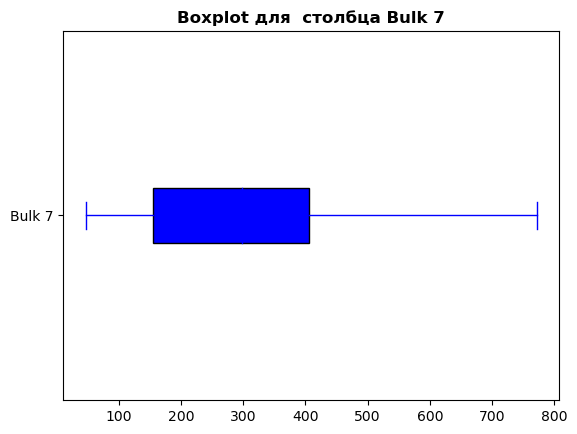

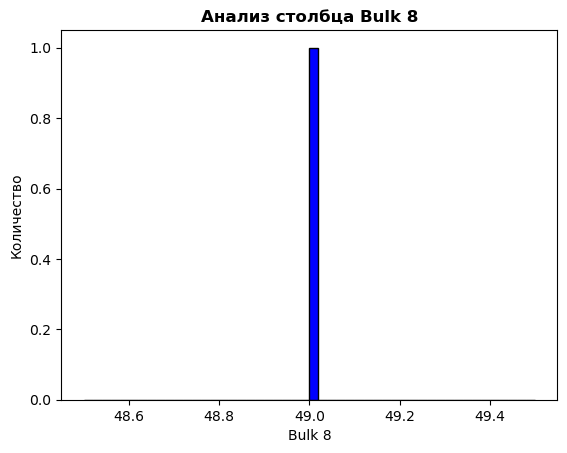

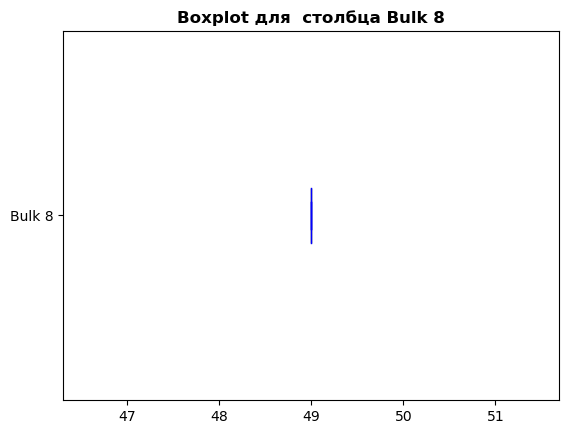

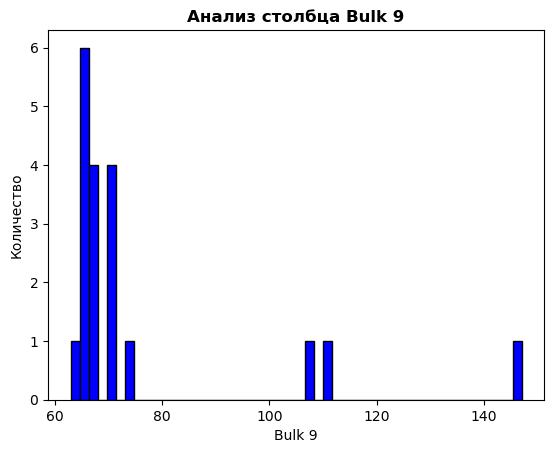

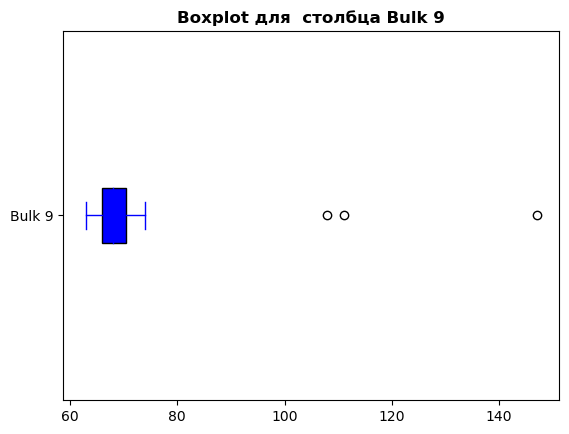

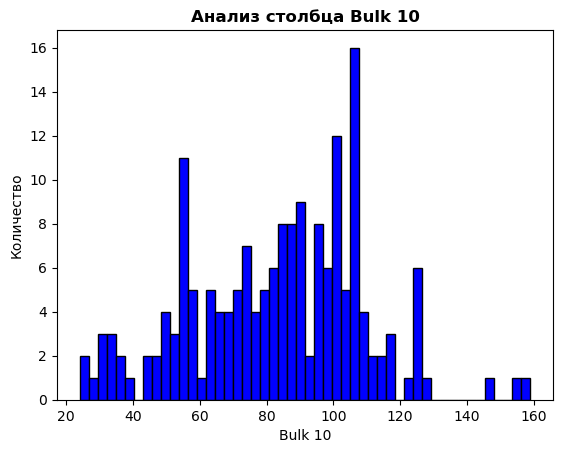

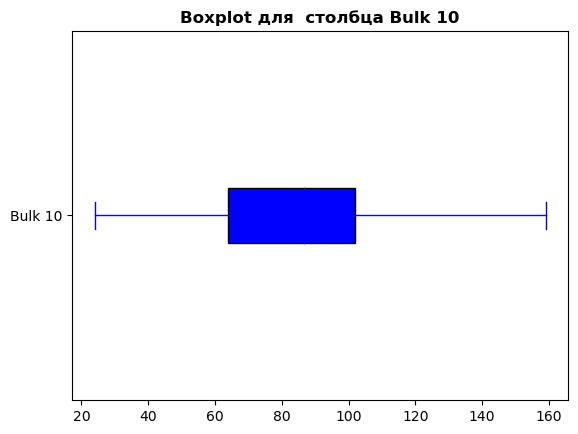

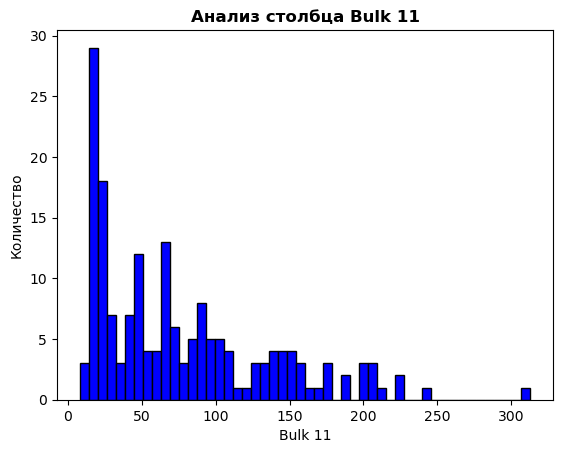

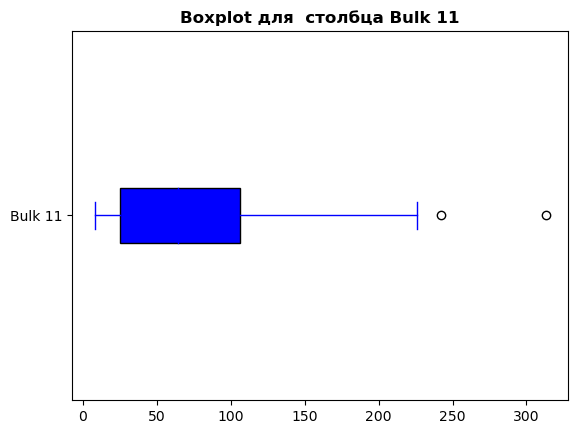

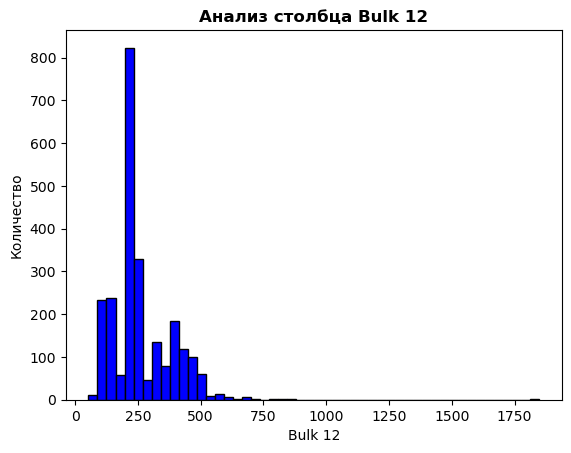

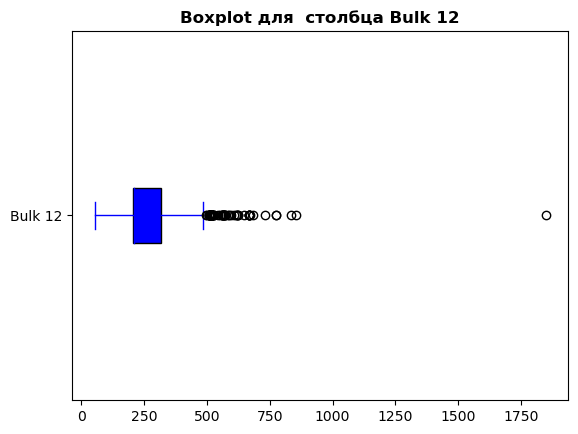

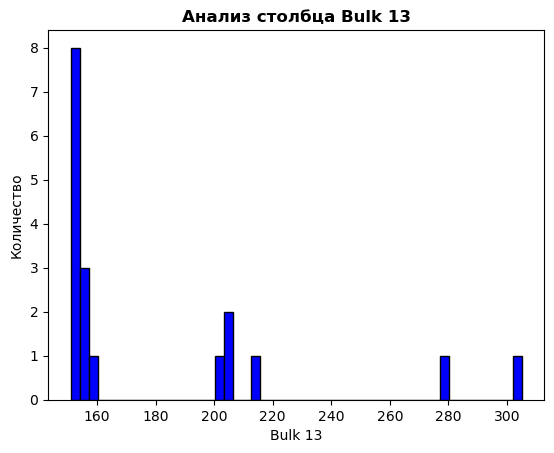

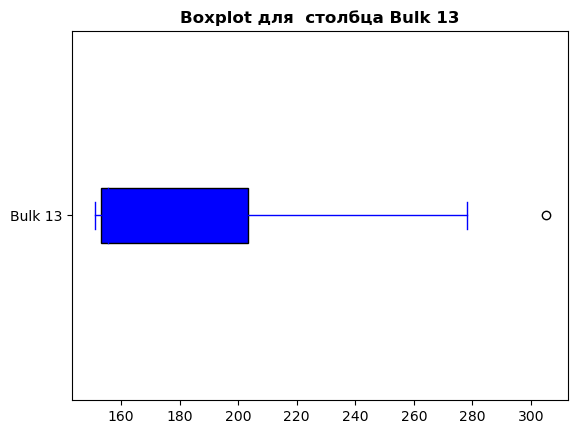

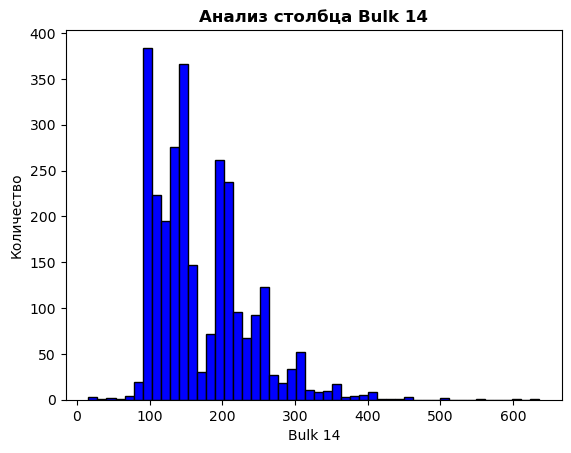

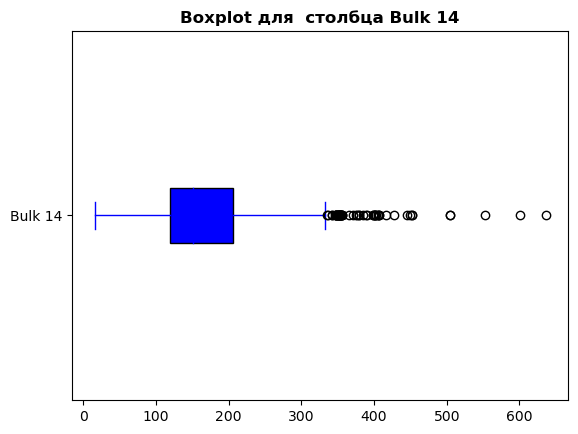

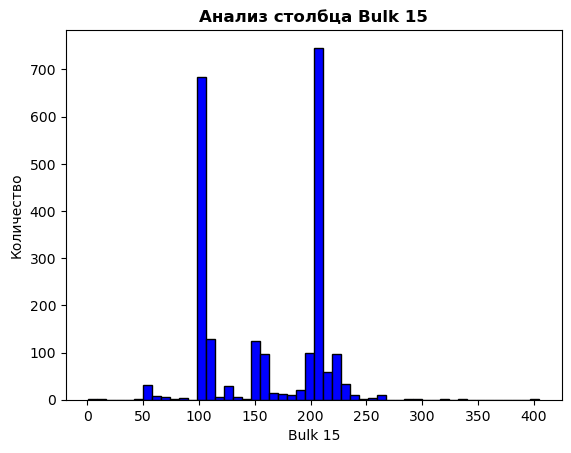

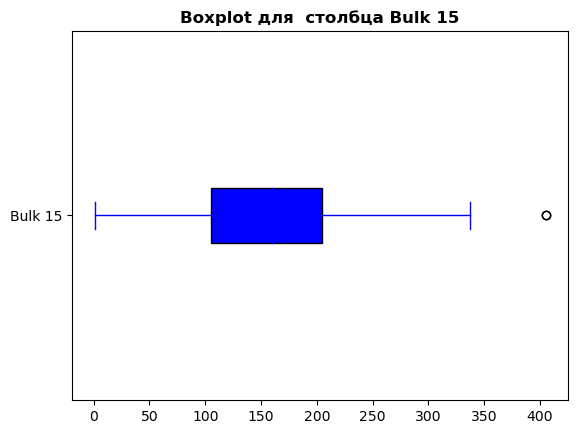

In [12]:
graphs(data_bulk_new,'data_bulk_new')

In [13]:
graphs(data_bulk_time_new,'data_bulk_time_new')

'Анализ количественных признаков датафрейма data_bulk_time_new'

'Анализ количественных признаков датафрейма data_gas_new'

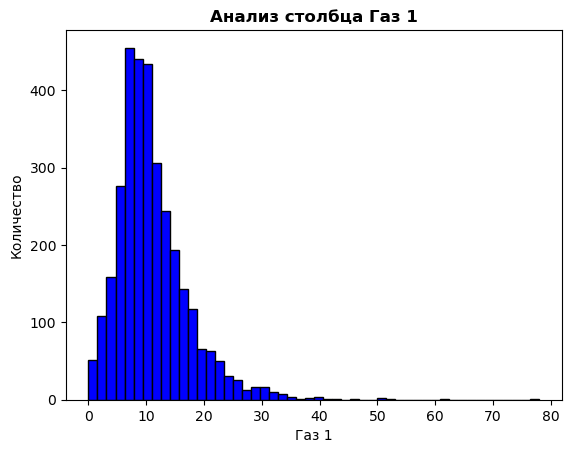

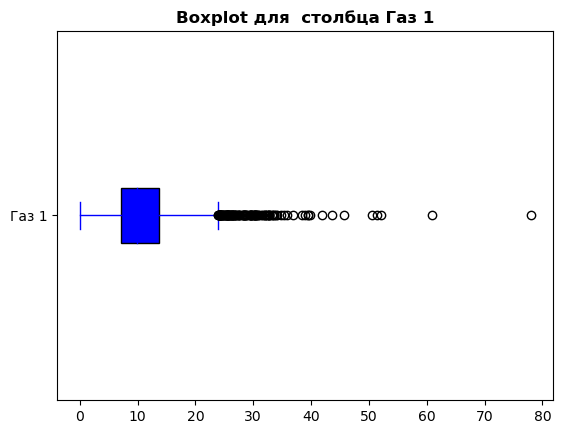

In [14]:
graphs(data_gas_new,'data_gas_new')

'Анализ количественных признаков датафрейма data_temp_new'

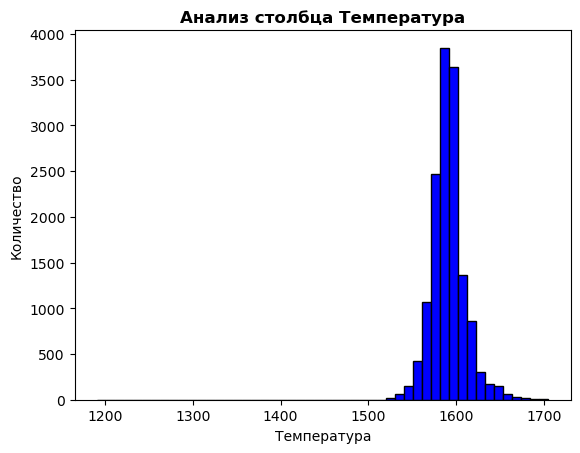

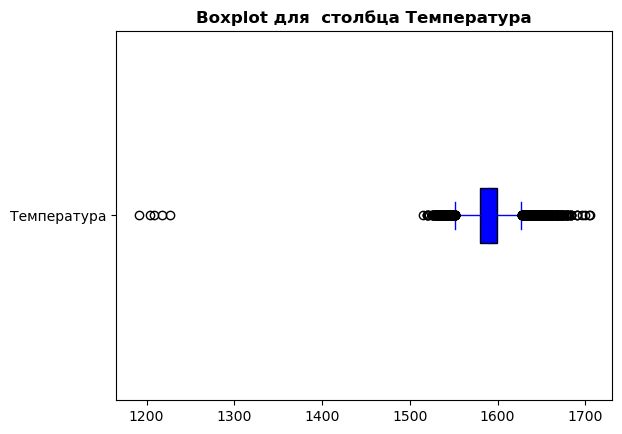

In [15]:
graphs(data_temp_new,'data_temp_new')

'Анализ количественных признаков датафрейма data_wire_new'

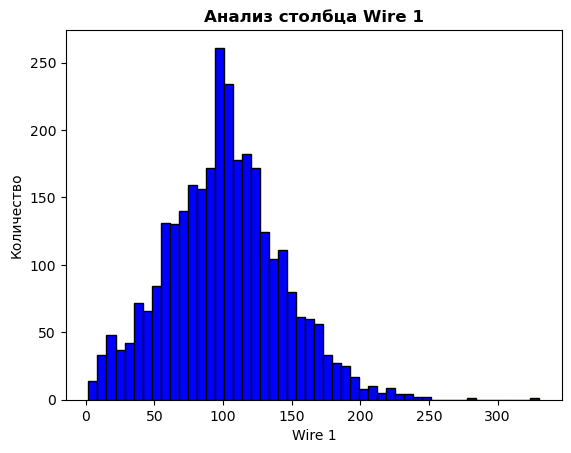

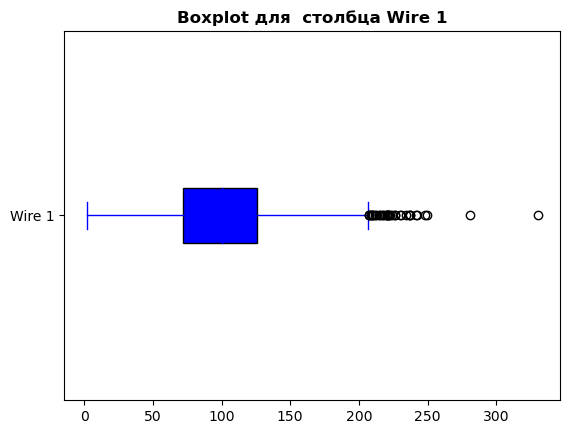

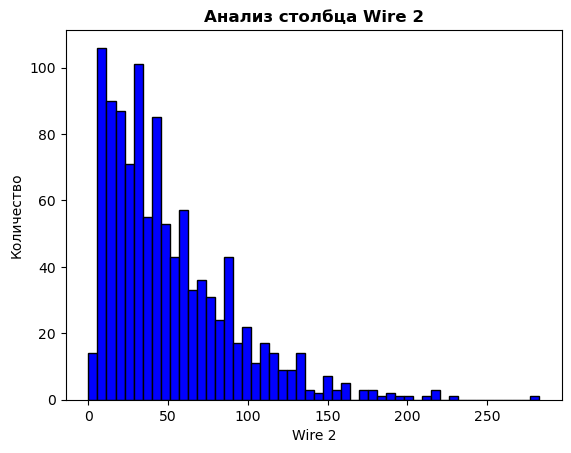

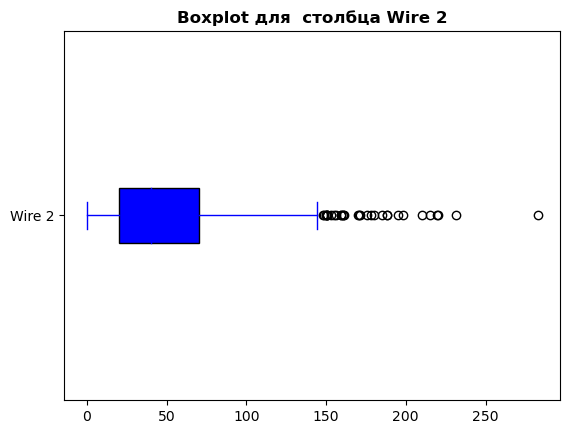

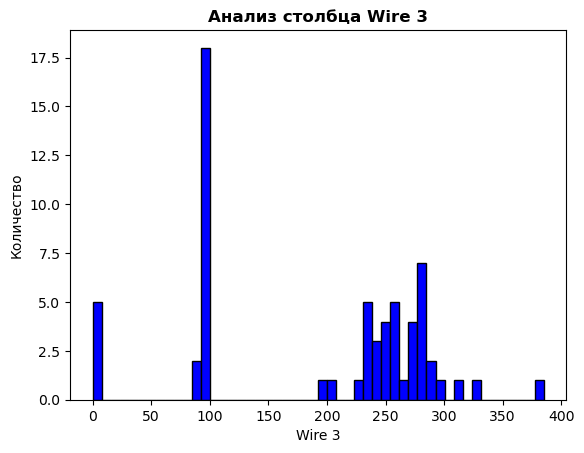

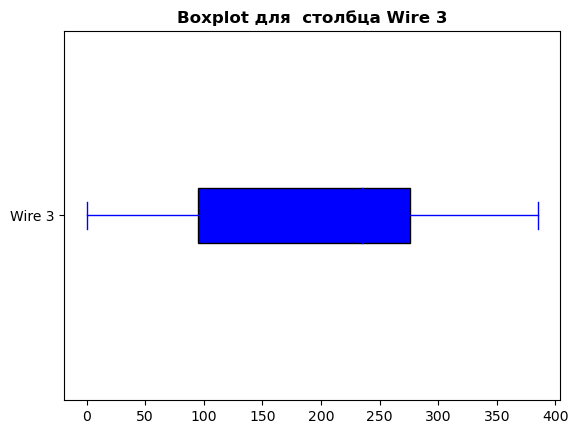

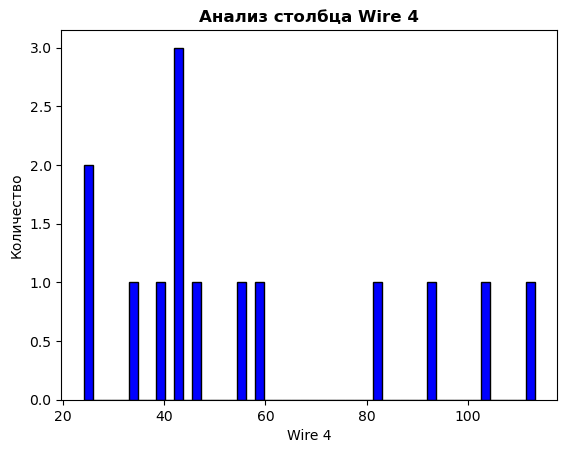

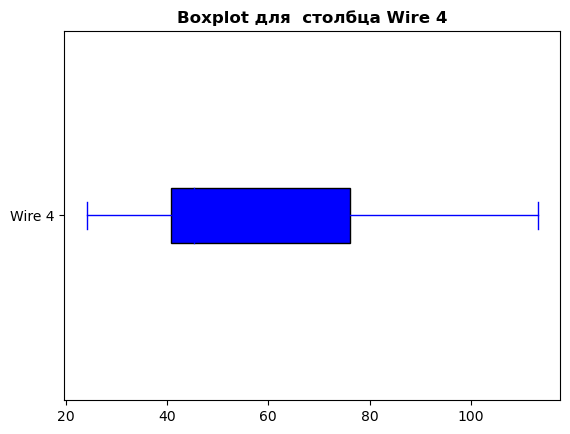

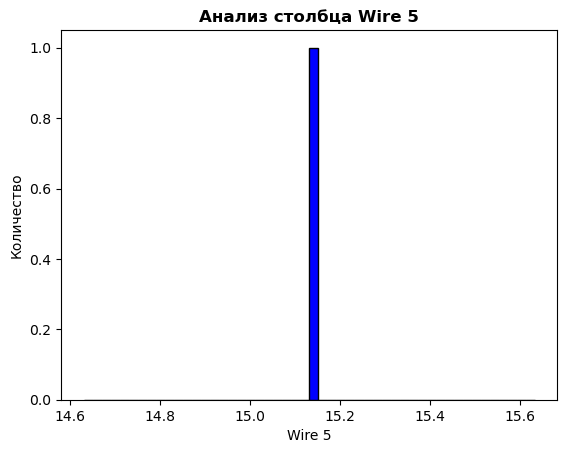

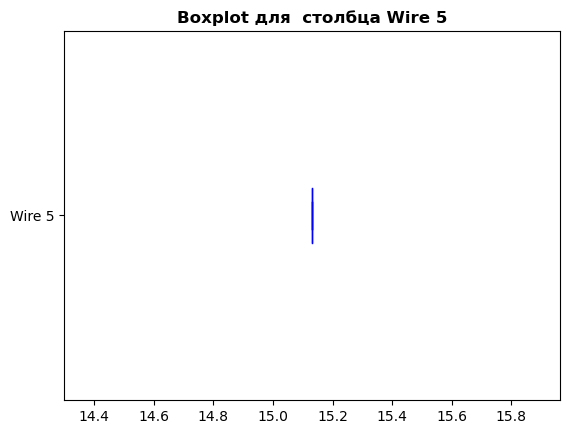

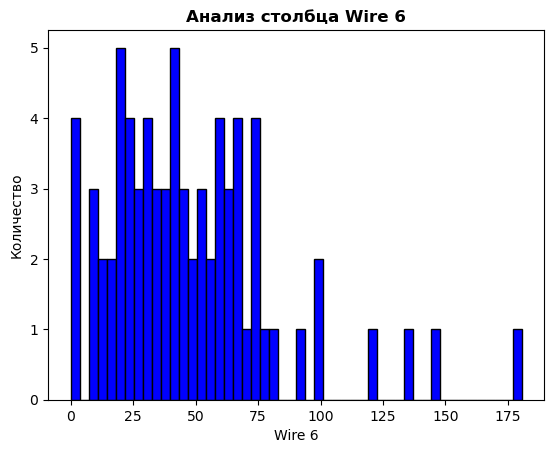

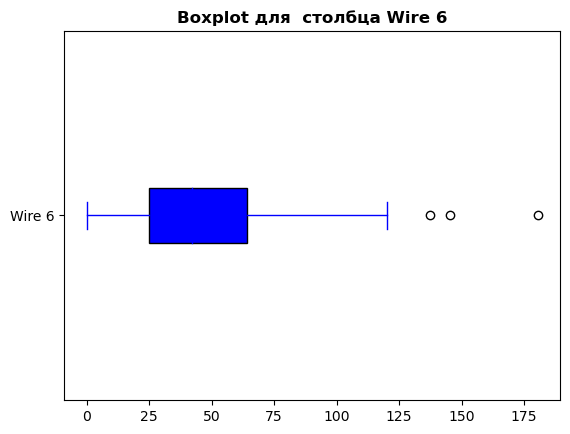

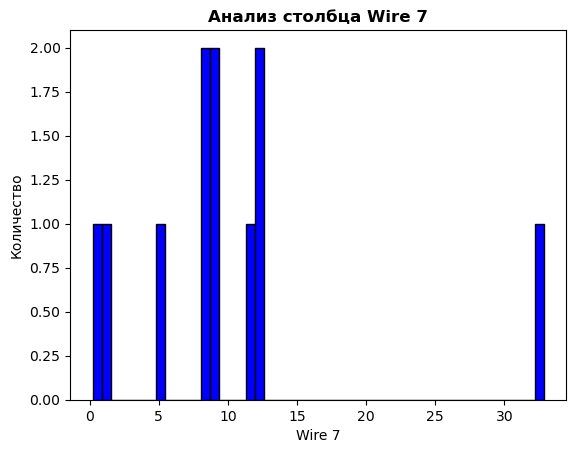

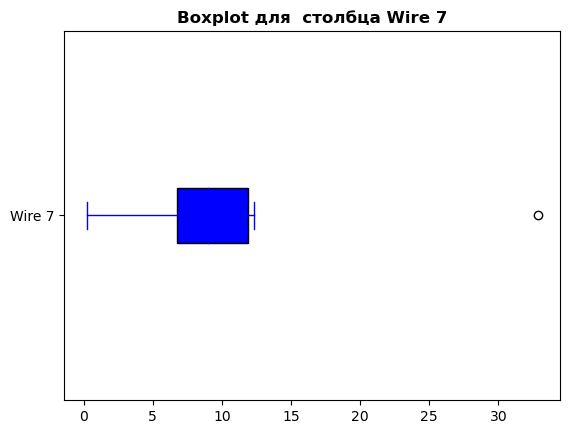

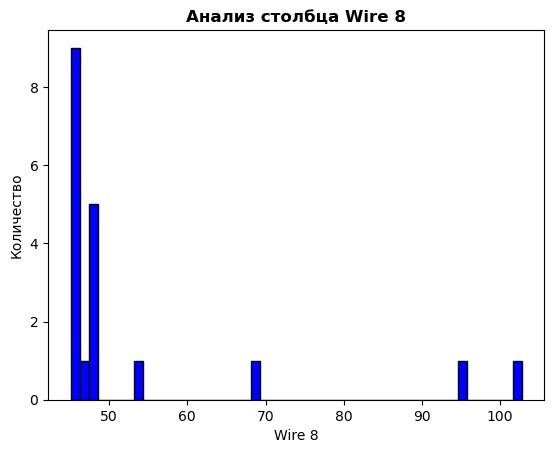

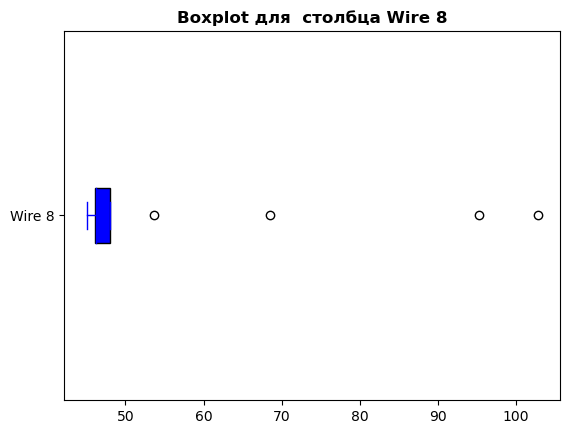

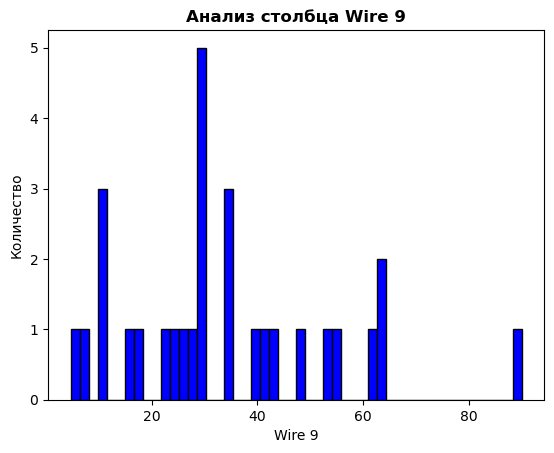

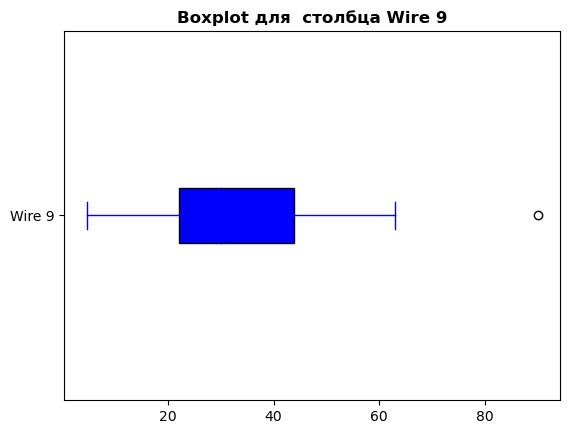

In [16]:
graphs(data_wire_new,'data_wire_new')

In [17]:
graphs(data_wire_time_new,'data_wire_time_new')

'Анализ количественных признаков датафрейма data_wire_time_new'

In [18]:
key_delete=list(data_arc_new.query('`Реактивная мощность`<0')['key'])
data_arc_2=data_arc_new.drop(index=data_arc_new.query('key in @key_delete').index)
display(data_arc_2)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0         1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1         1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2         1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3         1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4         1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   
...     ...                  ...                  ...                ...   
14871  3241  2019-09-06 16:49:05  2019-09-06 16:51:42           0.439735   
14872  3241  2019-09-06 16:55:11  2019-09-06 16:58:11           0.646498   
14873  3241  2019-09-06 17:06:48  2019-09-06 17:09:52           1.039726   
14874  3241  2019-09-06 17:21:58  2019-09-06 17:22:55           0.530267   
14875  3241  2019-09-06 17:24:54  2019-09-06 17:26:15           0.389057   

       Реактивная мощность  
0                 0.211253  
1                 0.477438  
2                 0.430460  
3                 0.379979  
4                 0.643691  
...                    ...  
14871             0.299579  
14872             0.458240  
14873             0.769302  
14874             0.361543  
14875             0.251347  

[14872 rows x 5 columns]

In [19]:
key_delete=list(data_temp_new.query('`Температура`<1500')['key'])
key_delete.extend(list(pd.pivot_table(data_temp_new,index='key', values='Температура',aggfunc='count').query('`Температура`==1').index))
data_temp_new_2=data_temp_new.drop(index=data_temp_new.query('key in @key_delete').index)
data_temp_new_2.head()

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

In [20]:
data_temp_new_2['Время замера']=pd.to_datetime(data_temp_new_2['Время замера'])
display(data_temp_new_2.info())
check=data_temp_new_2.groupby(by='key')[['Время замера']].min().merge(data_temp_new_2.groupby(by='key')[['Время замера']].max(),on='key', suffixes=['_first','_last']).reset_index()
temp=check.merge(data_temp_new_2.rename(columns={'Температура':'Температура_first'}),left_on=['key','Время замера_first'],right_on=['key','Время замера'],how='left').drop('Время замера',axis=1).merge(data_temp_new_2.rename(columns={'Температура':'Температура_last'}),left_on=['key','Время замера_last'],right_on=['key','Время замера'],how='left').drop('Время замера',axis=1)

temp.query('`Температура_first`.isna() or `Температура_last`.isna()')
temp

<class 'pandas.core.frame.DataFrame'>
Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13903 non-null  int64         
 1   Время замера  13903 non-null  datetime64[ns]
 2   Температура   13903 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


None

key  Время замера_first   Время замера_last  Температура_first  \
0        1 2019-05-03 11:02:04 2019-05-03 11:30:38             1571.0   
1        2 2019-05-03 11:34:04 2019-05-03 11:55:09             1581.0   
2        3 2019-05-03 12:06:44 2019-05-03 12:35:57             1596.0   
3        4 2019-05-03 12:39:27 2019-05-03 12:59:47             1601.0   
4        5 2019-05-03 13:11:03 2019-05-03 13:36:39             1576.0   
...    ...                 ...                 ...                ...   
2466  2495 2019-08-10 11:27:47 2019-08-10 11:50:47             1570.0   
2467  2496 2019-08-10 11:56:48 2019-08-10 12:25:13             1554.0   
2468  2497 2019-08-10 12:37:26 2019-08-10 12:53:28             1571.0   
2469  2498 2019-08-10 12:58:11 2019-08-10 13:23:31             1591.0   
2470  2499 2019-08-10 13:33:21 2019-08-10 13:58:58             1569.0   

      Температура_last  
0               1613.0  
1               1602.0  
2               1599.0  
3               1625.0  
4               1602.0  
...                ...  
2466            1591.0  
2467            1591.0  
2468            1589.0  
2469            1594.0  
2470            1603.0  

[2471 rows x 5 columns]

#### Вывод:
По результатам обработки убраны строки с номерами ключей более 2500

In [21]:
data_arc_2['Конец нагрева дугой']=pd.to_datetime(data_arc_2['Конец нагрева дугой'])
data_arc_2['Начало нагрева дугой']=pd.to_datetime(data_arc_2['Начало нагрева дугой'])
data_arc_2['Полная мощность']=(data_arc_2['Активная мощность']**2+data_arc_2['Реактивная мощность']**2)**0.5
data_arc_2['Время нагрева дугой']=(data_arc_2['Конец нагрева дугой']-data_arc_2['Начало нагрева дугой']).dt.seconds
arc=data_arc_2.groupby('key')[['Активная мощность', 'Реактивная мощность','Полная мощность']].mean().merge(data_arc_2.groupby('key')[['Время нагрева дугой']].sum(), on='key', how='left').reset_index()
arc

key  Активная мощность  Реактивная мощность  Полная мощность  \
0        1           0.607346             0.428564         0.743747   
1        2           0.534852             0.363339         0.647087   
2        3           0.812728             0.587491         1.003845   
3        4           0.676622             0.514248         0.850010   
4        5           0.563238             0.421998         0.704245   
...    ...                ...                  ...              ...   
3208  3237           0.508374             0.405083         0.650131   
3209  3238           0.458274             0.346034         0.574646   
3210  3239           0.606001             0.442693         0.751810   
3211  3240           0.663536             0.474710         0.816584   
3212  3241           0.609057             0.428002         0.744576   

      Время нагрева дугой  
0                    1098  
1                     811  
2                     655  
3                     741  
4                     869  
...                   ...  
3208                  909  
3209                  546  
3210                 1216  
3211                  839  
3212                  659  

[3213 rows x 5 columns]

#### Вывод:
Для датафрейма data_arc_new вычислен параметр "Полная мощность", "Время нагрева дугой"

### Шаг 3. Объединение данных

In [22]:
final=arc
merge_dataframes=[temp,data_bulk_new,data_gas_new,data_wire_new]
for i in merge_dataframes:
    final=final.merge(i, on='key', how='inner')
    

    
column_list=[]
for j in final.columns:
    if (final[j].isna().sum())/len(final[j])>0.8:
        column_list.append(j)
    if final[j].dtype=='datetime':
        column_list.append(j)
if len(column_list)>0:
    zhopa=list(final.select_dtypes(include=['datetime']).columns)
    column_list.extend(list(final.select_dtypes(include=['datetime']).columns))
    final=final.drop(column_list,axis=1).fillna(0).set_index('key')

display(final.tail())
display(f'Размер обьединенного датафрейма {final.shape}')


Активная мощность  Реактивная мощность  Полная мощность  \
key                                                             
2495           0.792033             0.552734         0.967180   
2496           0.695820             0.478672         0.845053   
2497           1.201746             0.817364         1.453639   
2498           0.640462             0.447964         0.781983   
2499           0.434271             0.324209         0.542313   

      Время нагрева дугой  Температура_first  Температура_last  Bulk 3  \
key                                                                      
2495                  723             1570.0            1591.0    21.0   
2496                  940             1554.0            1591.0     0.0   
2497                  569             1571.0            1589.0     0.0   
2498                  750             1591.0            1594.0    90.0   
2499                  883             1569.0            1603.0    47.0   

      Bulk 4  Bulk 12  Bulk 14  Bulk 15      Газ 1      Wire 1    Wire 2  
key                                                                       
2495     0.0    256.0    129.0    223.0   7.125735   89.150879   0.00000  
2496    63.0    256.0    129.0    226.0   9.412616  114.179527   0.00000  
2497    85.0    230.0    124.0    226.0   6.271699   94.086723   9.04800  
2498     0.0    206.0    129.0    207.0  14.953657  118.110717   0.00000  
2499     0.0    233.0    126.0    227.0  11.336151  110.160958  50.00528

'Размер обьединенного датафрейма (2324, 14)'

#### Вывод:
Обьединены пять датафреймов, удалены столбцы с количеством пропусков более 80 процентов. Удален столбец 'key'

'Анализ признаков итогового датафрейма'

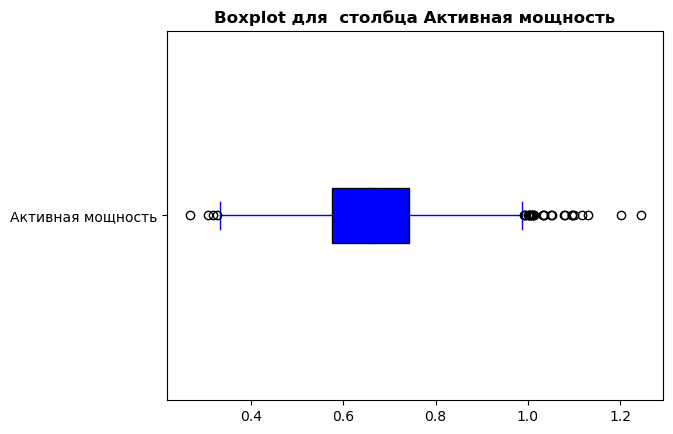

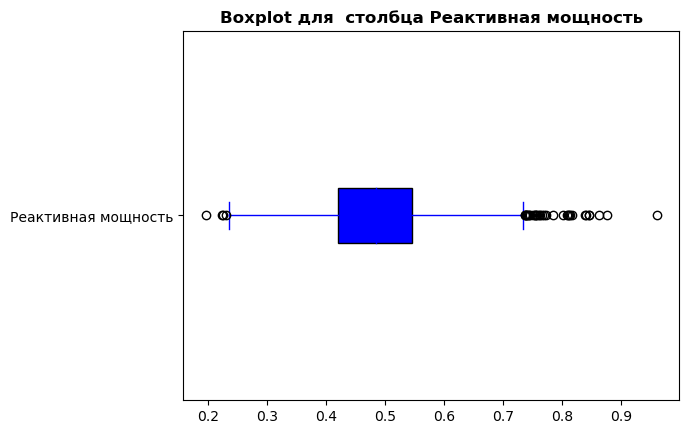

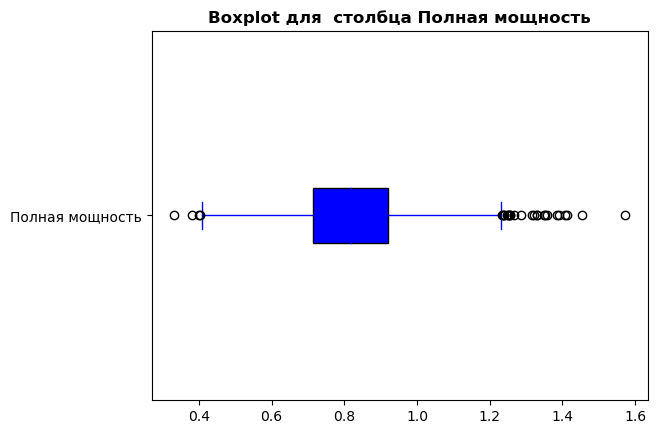

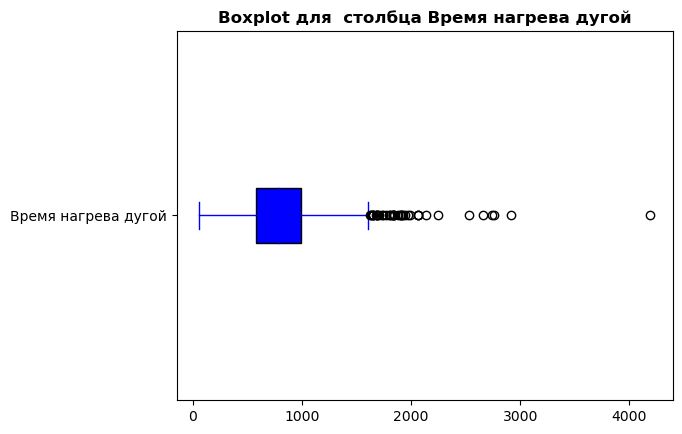

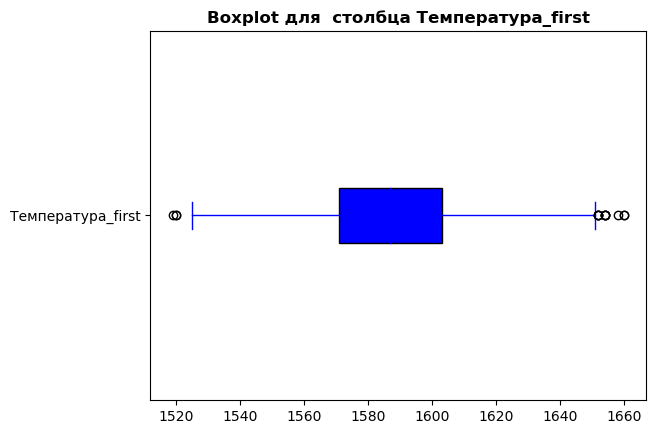

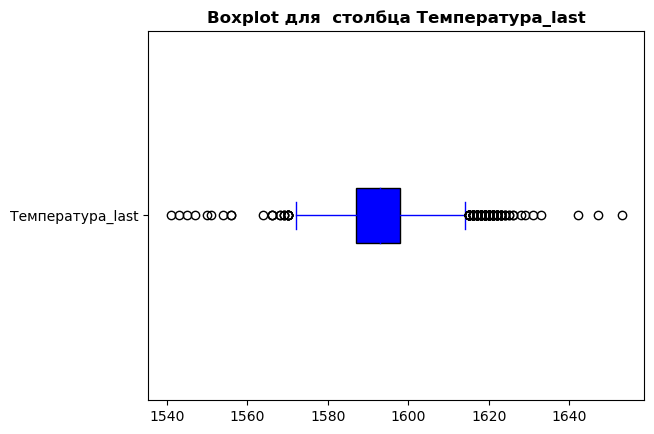

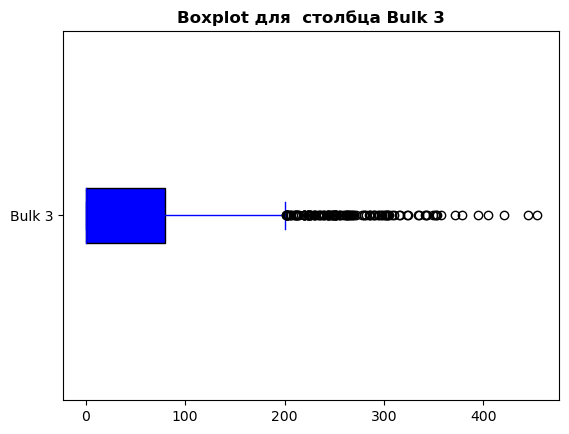

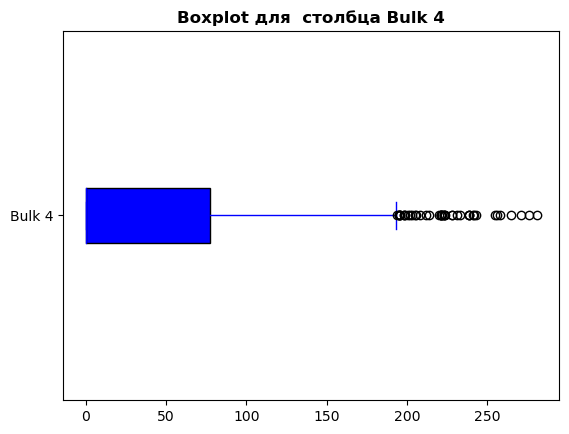

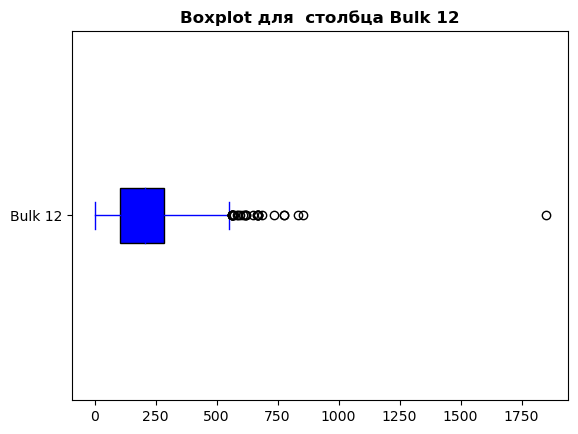

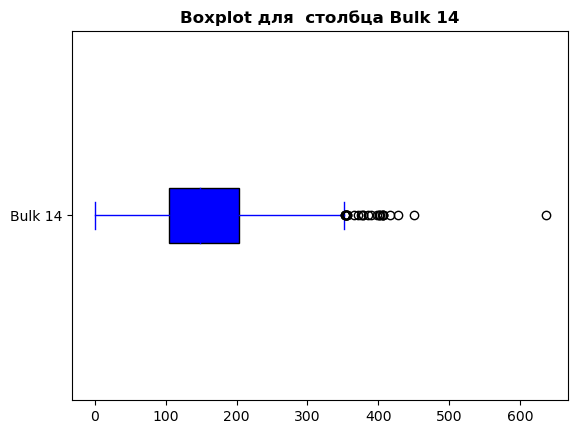

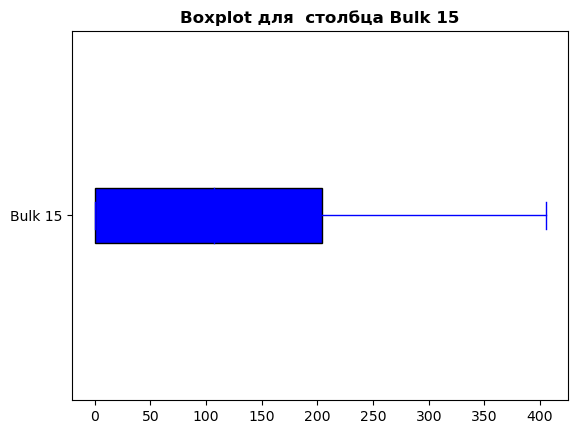

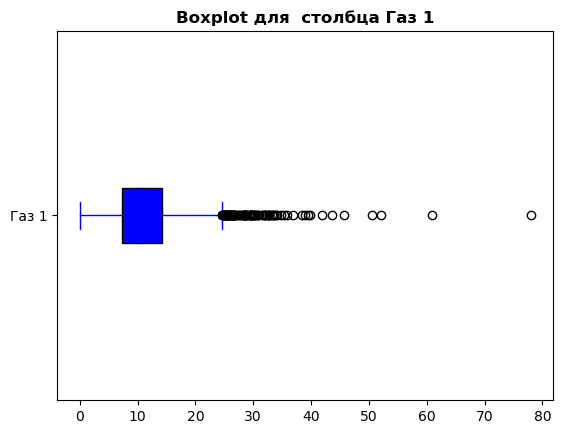

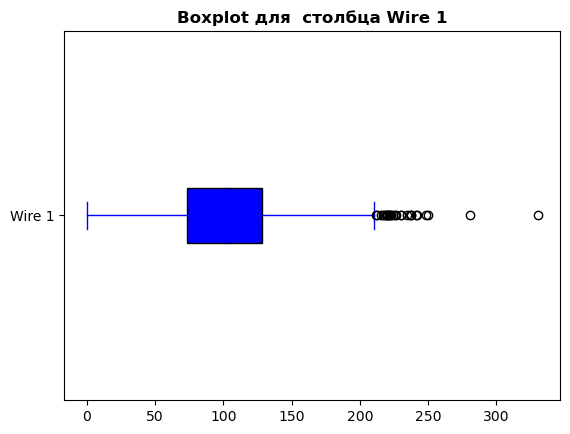

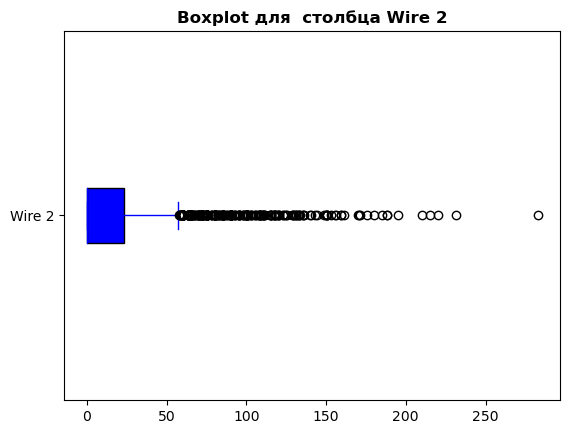

In [34]:
display('Анализ признаков итогового датафрейма')
for j in final.columns:
    final.boxplot([j],vert=False, patch_artist = True, boxprops = dict(facecolor = "blue"), grid= False, color='blue')
    plt.title(f'Boxplot для  столбца {j}',fontweight = "bold")
    plt.show()

#### Вывод:
По результатам построения боксплотов для всех признаков можно сделать вывод, что имеются признаки с выбросами, но пока не станем удалять строки с такими аномалиями ( может и с такими качеством датафрейма можно получить требуемое качество модели MAE<=6.8)

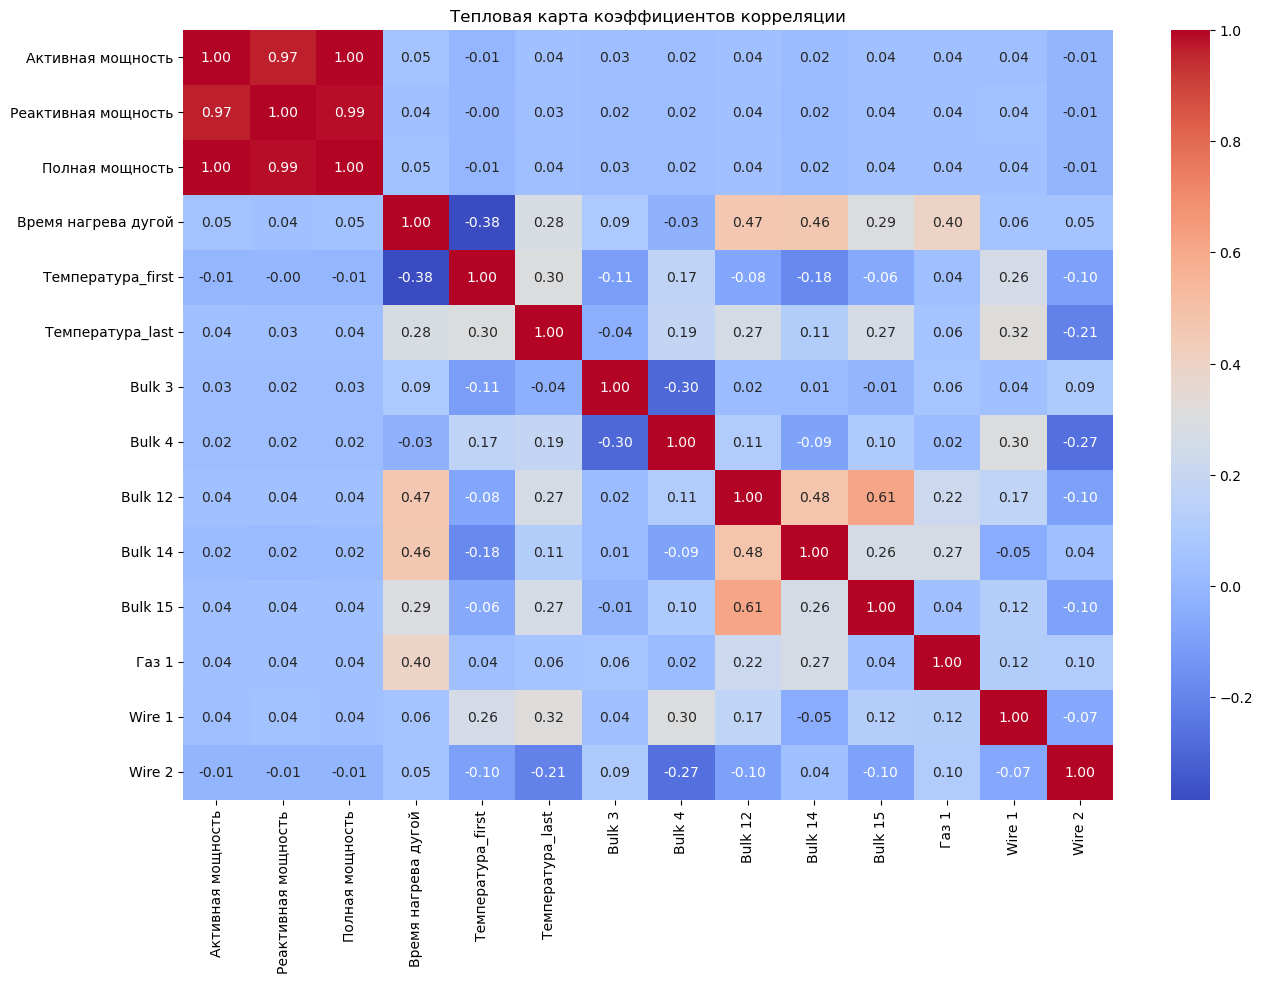

In [23]:
# import phik
#interval_cols = ['Активная мощность', 'Реактивная мощность', 'Полная мощность','Время нагрева дугой','Температура_first', 'Температура_last', 'Bulk 3', 'Bulk 4', 'Bulk 12','Bulk 14', 'Bulk 15', 'Газ 1', 'Wire 1', 'Wire 2'] 
#phik_matrix = final.phik_matrix(interval_cols =interval_cols,drop_underflow=False, drop_overflow=False)
# Делал сначала с помощью phik, но почему-то вылетает из-за ошибки деления на 0


plt.figure(figsize=(15, 10))
sns.heatmap(final.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Тепловая карта коэффициентов корреляции")
plt.show()

#### Вывод:

По результатам построенной тепловая карты коэффициентов корреляции для обьединенного датафрейма можно сделать вывод, что целевой признак 'Температура_last' коррелирует с "временем нагрева дугой" и "температура_first", количеством подачи материала (Bulk 12,Bulk 15,Wire 1)

### Шаг 4. Обучение моделей машинного обучения

In [24]:
RANDOM_STATE=20924
TEST_SIZE=0.25

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    final.drop('Температура_last', axis=1),
    final['Температура_last'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)
display(f'Размер обучающей выборки X_train {X_train.shape}')
display(f'Размер тестовой выборки выборки X_test {X_test.shape}')

'Размер обучающей выборки X_train (1743, 13)'

'Размер тестовой выборки выборки X_test (581, 13)'

In [26]:
model = CatBoostRegressor() 
parameters = [{'learning_rate':[0.06, 0.065, 0.07, 0.075, 0.08], 'random_state':[RANDOM_STATE], 'verbose':[False]}]
model_cbr = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
model_cbr.fit(X_train, y_train)

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x168732a90>,
             param_grid=[{'learning_rate': [0.06, 0.065, 0.07, 0.075, 0.08],
                          'random_state': [20924], 'verbose': [False]}],
             scoring='neg_mean_absolute_error')

In [27]:
model_lgbmr = LGBMRegressor(verbosity=-1) 
parameters = [{'learning_rate':[0.03, 0.04, 0.05, 0.06, 0.07], 'max_depth': [3, 4, 7], 'random_state':[RANDOM_STATE]}]
model_lgbmr = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
model_lgbmr.fit(X_train, y_train)

0:	learn: 11.4635218	total: 346us	remaining: 346ms
1:	learn: 11.4043735	total: 818us	remaining: 408ms
2:	learn: 11.3506407	total: 1.08ms	remaining: 360ms
3:	learn: 11.2862249	total: 1.59ms	remaining: 397ms
4:	learn: 11.2279005	total: 1.92ms	remaining: 382ms
5:	learn: 11.1738111	total: 2.16ms	remaining: 358ms
6:	learn: 11.1272457	total: 2.51ms	remaining: 356ms
7:	learn: 11.0812267	total: 2.78ms	remaining: 344ms
8:	learn: 11.0239770	total: 3.02ms	remaining: 333ms
9:	learn: 10.9644531	total: 3.3ms	remaining: 326ms
10:	learn: 10.9213732	total: 3.59ms	remaining: 323ms
11:	learn: 10.8781316	total: 3.92ms	remaining: 323ms
12:	learn: 10.8287482	total: 4.34ms	remaining: 330ms
13:	learn: 10.7853184	total: 4.6ms	remaining: 324ms
14:	learn: 10.7339371	total: 5.11ms	remaining: 335ms
15:	learn: 10.6861342	total: 5.43ms	remaining: 334ms
16:	learn: 10.6386672	total: 5.75ms	remaining: 332ms
17:	learn: 10.5993409	total: 6.1ms	remaining: 333ms
18:	learn: 10.5668859	total: 6.48ms	remaining: 334ms
19:	lear

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x168732a90>,
             param_grid=[{'learning_rate': [0.03, 0.04, 0.05, 0.06, 0.07],
                          'max_depth': [3, 4, 7], 'random_state': [20924]}],
             scoring='neg_mean_absolute_error')

In [28]:
display(f'MAE LGBMRegressor на тренировочной выборке {round(abs(model_lgbmr.best_score_), 2)}')
display(f'Лучшие параметры модели LGBMRegressor {model_lgbmr.best_params_}')
display(f'MAE CatBoostRegressor на тренировочной выборке {round(abs(model_cbr.best_score_), 2)}')
display(f'Лучшие параметры модели CatBoostRegressor {model_cbr.best_params_}')

'MAE LGBMRegressor на тренировочной выборке 6.57'

"Лучшие параметры модели LGBMRegressor {'learning_rate': 0.03, 'max_depth': 7, 'random_state': 20924}"

'MAE CatBoostRegressor на тренировочной выборке 6.67'

"Лучшие параметры модели CatBoostRegressor {'learning_rate': 0.06, 'random_state': 20924, 'verbose': False}"

#### Вывод:
По результатам обучения параметр MAE наилучший у модели LGBMRegressor {'learning_rate': 0.03, 'max_depth': 7, 'random_state': 20924} 6.57. Для работы выбрана данная модель.

In [29]:
model = DummyRegressor()
parameters = [{'strategy':['mean', 'median', 'quantile'], 'quantile':[0.0,0.5, 1.0]}]
model_DR= GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
model_DR.fit(X_train, y_train)
display(f'MAE DummyRegressor на тренировочной выборке {round(abs(model_DR.best_score_), 2)}')
display(f'Лучшие параметры модели DummyRegressor {model_DR.best_params_}')

'MAE DummyRegressor на тренировочной выборке 8.23'

"Лучшие параметры модели DummyRegressor {'quantile': 0.0, 'strategy': 'median'}"

#### Вывод:

MAE DummyRegressor на тренировочной выборке 8.23 это указывает на то, что модель имеет относительно высокий уровень ошибки. Это означает, что прогнозы, сделанные моделью, значительно отличаются от истинных значений в наборе данных.

### Шаг 5. Выбор лучшей модели

In [30]:
y_pred=model_lgbmr.predict(X_test)
display(f'R2 на тестовой выборке {round(r2_score(y_test, y_pred),2)}')
display(f'MAE на тестовой выборке {round(mean_absolute_error(y_test, y_pred),2)}')

'R2 на тестовой выборке 0.3'

'MAE на тестовой выборке 6.21'

#### Вывод:
MAE на тестовой выборке составил 6,21, что соответствует ТЗ. Коэффициент детерминации составляет 0.3-это указывает на то, что модель объясняет примерно 30% вариации данных. Это означает, что большая часть изменчивости зависимой переменной не объясняется моделью, и существуют другие факторы, влияющие на результат, которые модель не учитывает.

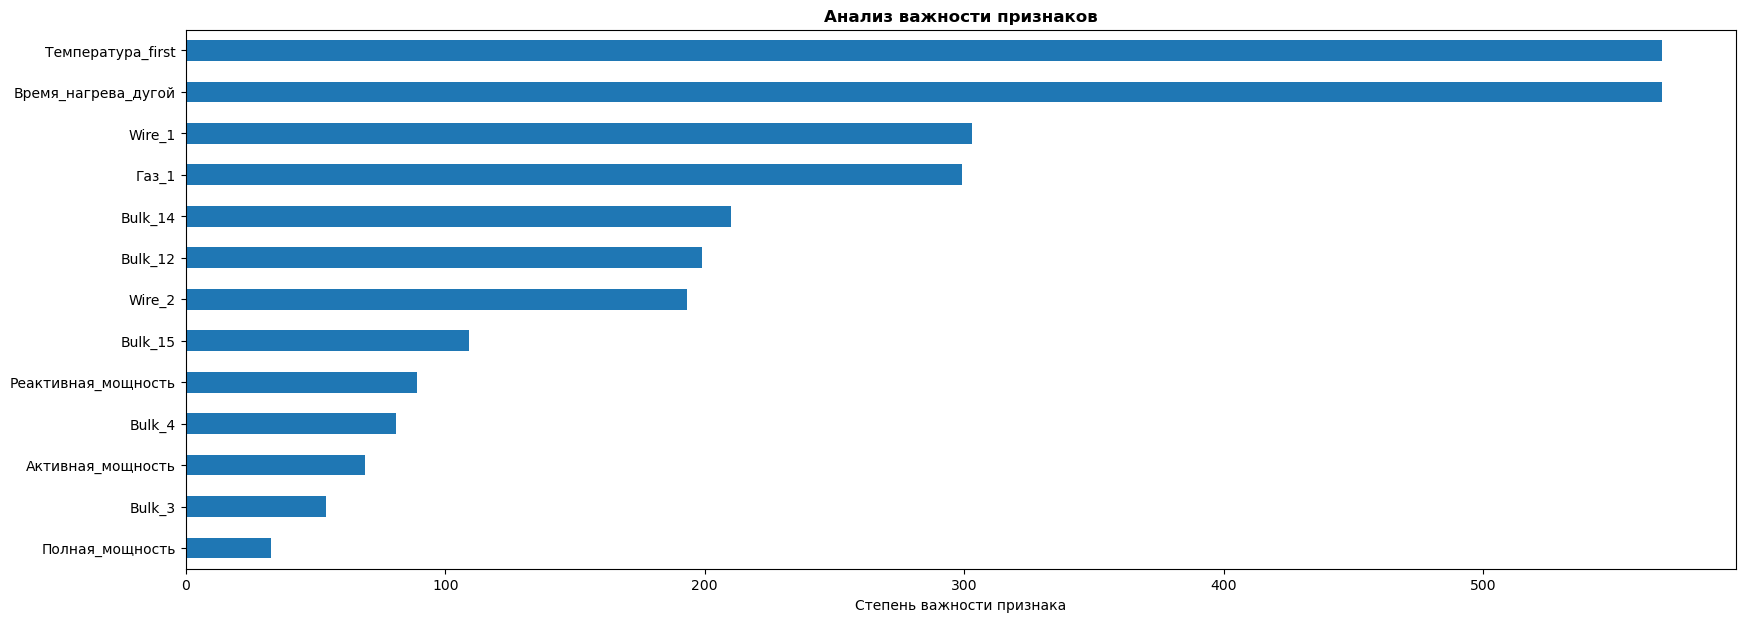

In [31]:
model = LGBMRegressor(verbosity=-1) 
LR_best_params=model_lgbmr.best_params_
model.set_params(**LR_best_params)
model.fit(X_train, y_train)

fig = pd.Series(model.booster_.feature_importance(),index=model.booster_.feature_name()).sort_values(ascending=True).plot.barh(figsize=(20,7))
plt.xlabel('Степень важности признака')
plt.title('Анализ важности признаков',fontweight = "bold")
plt.show()

#### Вывод:
Степень важности признаков наибольшая для температуры_first и времени нагрева. Это логично, ибо целевой признак непосредственно связана с процессом нагрева, описываемый тажке данными двумя этими признаками

# Итоговый вывод

- В data_arc_new отсутствуют пустые ячейки и дубликаты. Для столбцов в "Начало нагрева дугой" и "Конец нагрева дугой" необходимо извенить формат на datetime
- В data_bulk_new отсутствуют и дубликаты. Имеются пустые ячейки
- В data_bulk_time_new отсутствуют дубликаты. Имеются пустые ячейки. Для столбцов BULK необходимо извенить формат на datetime
- В data_gas_new отсутствуют пустые ячейки и дубликаты
- В data_temp_new отсутствуют дубликаты. Имеются пустые ячейки. Для столбца "Время замера" необходимо извенить формат на datetime
- В data_wire_new отсутствуют дубликаты. Имеются пустые ячейки
- В data_wire_time_new отсутствуют дубликаты. Имеются пустые ячейки. Для столбцов WIRE необходимо извенить формат на datetime
- data_arc_new['Реативная мощность'] есть выборос в -715 градусов
- По результатам обработки data_temp_new убраны строки с номерами ключей более 2500
Для датафрейма data_arc_new вычислен параметр "Полная мощность", "Время нагрева дугой"
- Обьединены пять датафреймов, удалены столбцы с количеством пропусков более 80 процентов. Удален столбец 'key'
- По результатам построенной тепловая карты коэффициентов корреляции для обьединенного датафрейма можно сделать вывод, что целевой признак 'Температура_last' коррелирует с "временем нагрева дугой" и "температура_first", количеством подачи материала (Bulk 12,Bulk 15,Wire 1)
- MAE DummyRegressor на тренировочной выборке 8.23 это указывает на то, что модель имеет относительно высокий уровень ошибки. Это означает, что прогнозы, сделанные моделью, значительно отличаются от истинных значений в наборе данных.
- По результатам обучения параметр MAE наилучший у модели LGBMRegressor {'learning_rate': 0.03, 'max_depth': 7, 'random_state': 20924} 6.57. Для работы выбрана данная модель.
- MAE на тестовой выборке составил 6,21, что соответствует ТЗ. Коэффициент детерминации составляет 0.3-это указывает на то, что модель объясняет примерно 30% вариации данных. Это означает, что большая часть изменчивости зависимой переменной не объясняется моделью, и существуют другие факторы, влияющие на результат, которые модель не учитывает.
- Степень важности признаков наибольшая для температуры_first и времени нагрева. Это логично, ибо целевой признак непосредственно связана с процессом нагрева, описываемый тажке данными двумя этими признаками
